In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from torch_mas.ciel import Ciel
from torch_mas.agents.agents_linear_reg import AgentsLinear
from torch_mas.agents.sgd_agents_linear_svm import AgentsLSVM
from torch_mas.agents.agents_linear_svm_sklearn import AgentsLSVMSKL
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np

from xgboost import XGBClassifier

In [4]:
from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, base_prediction: torch.Tensor, colors, alpha=0.4):

    for h, bp in zip(hypercubes,base_prediction):
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=colors[bp], alpha=alpha)
        ax.add_patch(patch)

In [25]:
# Full dataset can be downloaded here : https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
df = pd.read_csv('small_HIGGS.csv',header=None,usecols=[1,2,3])

In [26]:
df

,1,2,3
0,0.0,1.000000,2.000000
1,1.0,0.869293,-0.635082
2,1.0,0.907542,0.329147
3,1.0,0.798835,1.470639
4,0.0,1.344385,-0.876626
...,...,...,...
996,1.0,1.062917,-1.308094
997,1.0,0.687931,-0.765594
998,0.0,0.481497,-0.444184
999,1.0,0.564766,0.262917


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], df[df.columns[0]], random_state=0)

scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train.to_numpy())
X_test = scl.transform(X_test.to_numpy())

y_train_svm = np.where(y_train == 0,-1,1)
y_test_svm = np.where(y_test == 0,-1,1)

### Rounded linear regression

In [28]:
re = Ciel(
    2, 
    1, 
    R=0.5,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=5,
    n_epochs=5,
    agents=AgentsLinear
    )

re.fit(X_train, y_train.to_numpy())
y_pred = re.predict(X_test)
print(classification_report(y_test.round(), y_pred.round(),labels=[0,1]))

              precision    recall  f1-score   support

           0       0.41      0.32      0.36       119
           1       0.50      0.41      0.45       132

   micro avg       0.46      0.37      0.41       251
   macro avg       0.46      0.36      0.41       251
weighted avg       0.46      0.37      0.41       251



### SVM

In [29]:
re = Ciel(
    2, 
    1, 
    R=0.5,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=5,
    n_epochs=5,
    agents=AgentsLSVM
    )

re.fit(X_train, y_train_svm)
y_pred = re.predict(X_test)
print(classification_report(y_test_svm, y_pred,zero_division=0))

              precision    recall  f1-score   support

          -1       0.48      0.46      0.47       119
           1       0.53      0.55      0.54       132

    accuracy                           0.51       251
   macro avg       0.50      0.50      0.50       251
weighted avg       0.51      0.51      0.51       251



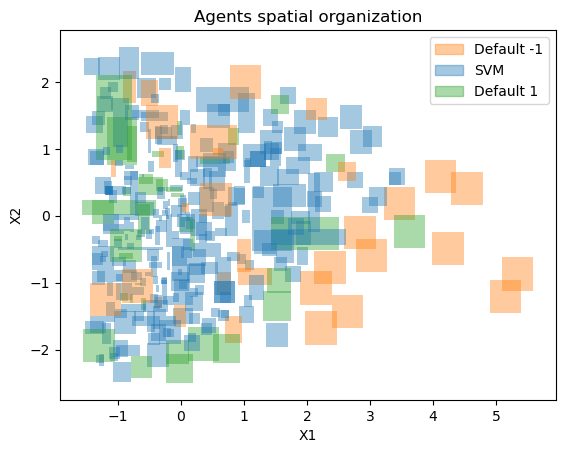

In [30]:
colors = {
    -1 : 'C1',
    0 : 'C0',
    1 : 'C2'
}

ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, re.estimator.agents.hypercubes.detach().numpy(), re.estimator.agents.base_prediction.numpy(),colors)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

custom_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[-1], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[0], alpha=0.4),
                  plt.Rectangle((0, 0), 1, 1, color=colors[1], alpha=0.4)]
custom_labels = ['Default -1', 'SVM', 'Default 1']

ax.legend(handles=custom_handles, labels=custom_labels)


### XGBoost

In [ ]:
bst = XGBClassifier()
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.48      0.38      0.42       117
         1.0       0.54      0.65      0.59       133

    accuracy                           0.52       250
   macro avg       0.51      0.51      0.51       250
weighted avg       0.51      0.52      0.51       250

